Здесь будет построена линейная модель для классификации твитов о аэрокомпаниях.

Задача, как можно увидеть ниже сводится к мультиклассовой классификации на 2 "категории" классов
- сентимент (negative/positive/neutral)
- с случае негативного сентимента - есть набор возможных причин
Т.е. решаются 2 задачи мультиклассовой классификации.

Валидация проводится следующим образом (для обоих классификаторов):
- фолды образуются при помощи stratified k-fold 
- оценивается "сбалансированная" точность (см. [balanced_accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html))
- также будут построены confusion-матрицы для всех классов

In [1]:
import os
from google.colab import drive

drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/job/epoch8-test/')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
%matplotlib inline
import functools
import re
import warnings
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer
from nltk.tokenize import TweetTokenizer
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, make_scorer, confusion_matrix

In [0]:
warnings.filterwarnings('ignore')

In [0]:
RANDOM_STATE = 42

In [4]:
df = pd.read_csv('Tweets.csv')
df.sample(10, random_state=RANDOM_STATE)

tweet_id airline_sentiment  airline_sentiment_confidence  \
4794   569731104070115329          positive                        1.0000   
10480  569263373092823040          negative                        1.0000   
8067   568818669024907264          negative                        1.0000   
8880   567775864679456768           neutral                        1.0000   
8292   568526521910079488          negative                        0.6625   
927    570008443626647552          negative                        1.0000   
3165   568622671287566336          negative                        1.0000   
7894   569076569983086592           neutral                        1.0000   
2818   568884344221081600          negative                        0.6869   
9145   570119853312311296          positive                        1.0000   

               negativereason  negativereason_confidence     airline  \
4794                      NaN                        NaN   Southwest   
10480        Cancelled Flight                     1.0000  US Airways   
8067              Late Flight                     0.6770       Delta   
8880                      NaN                        NaN       Delta   
8292   Customer Service Issue                     0.3394       Delta   
927                Can't Tell                     0.3477      United   
3165         Cancelled Flight                     0.6871      United   
7894                      NaN                        NaN       Delta   
2818               Can't Tell                     0.3434      United   
9145                      NaN                        NaN  US Airways   

      airline_sentiment_gold             name negativereason_gold  \
4794                     NaN        JasmineDT                 NaN   
10480                    NaN  ElizabethFrayer                 NaN   
8067                     NaN     The_Radifier                 NaN   
8880                     NaN        rnlewisjr                 NaN   
8292                     NaN         beantoon                 NaN   
927                      NaN         kabell87                 NaN   
3165                     NaN    stephaniefoos                 NaN   
7894                     NaN    theycallme_HH                 NaN   
2818                     NaN      andreamvdlg                 NaN   
9145                     NaN      GrahamHaigh                 NaN   

       retweet_count                                               text  \
4794               1  @SouthwestAir you're my early frontrunner for ...   
10480              0  @USAirways how is it that my flt to EWR was Ca...   
8067               0  @JetBlue what is going on with your BDL to DCA...   
8880               0  @JetBlue do they have to depart from Washingto...   
8292               0  @JetBlue I can probably find some of them. Are...   
927                0  @united still waiting to hear back. My wallet ...   
3165               0  @united Yes my flight was rebooked. I'm just l...   
7894               0  @JetBlue Thank you ! What about Paris ? Could ...   
2818               0  @united not 100% sure, however my ticket inclu...   
9145               0  @usairways great crew for flight 504 PHX to YV...   

                      tweet_coord              tweet_created  \
4794                          NaN  2015-02-22 21:30:54 -0800   
10480                         NaN  2015-02-21 14:32:19 -0800   
8067                          NaN  2015-02-20 09:05:13 -0800   
8880                          NaN  2015-02-17 12:01:29 -0800   
8292                          NaN  2015-02-19 13:44:20 -0800   
927                           NaN  2015-02-23 15:52:57 -0800   
3165   [40.69522398, -74.1760931]  2015-02-19 20:06:23 -0800   
7894                   [0.0, 0.0]  2015-02-21 02:10:01 -0800   
2818                          NaN  2015-02-20 13:26:11 -0800   
9145                          NaN  2015-02-23 23:15:40 -0800   

                      tweet_location               user_timezone  
4794              

# Обзор данных

Оценим число пропущенных значений:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


Т.е. присутствуют следующие поля:
- ```airline_sentiment```/```airline_sentiment_confidence```
- в части случаев - ```negativereason```/```negativereason_confidence```
- ```airline```
- ```airline_sentiment_gold``` (задано лишь в 40 случаях)
- ```negativereason_gold``` (задано 32 раза)

Также оценим распределение классов обоих целевых переменных:

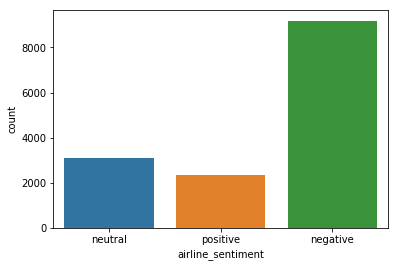

In [6]:
sns.countplot(df['airline_sentiment'])

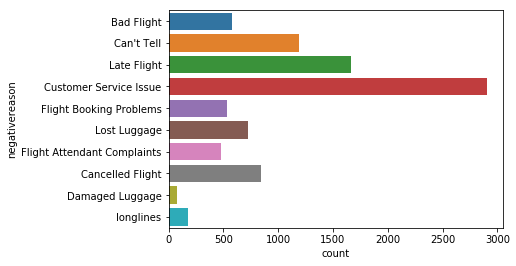

In [7]:
sns.countplot(y=df['negativereason'])

Как видно - мы будем работать с несбалансированной классификацией

# Генерация фолдов

Ниже добавлена функция построения фолдов для кросс-валидаци такая, что полученные фолды совпадают с фолдами в модели на BERT:

In [0]:
def generate_folds(df, dropna_subset=None):
  cv = StratifiedKFold(n_splits=3, random_state=RANDOM_STATE)
  for train_idx, test_idx in cv.split(df['text'], df['airline_sentiment']):
    df_train = df.iloc[train_idx].reset_index(drop=True)
    df_test = df.iloc[test_idx].reset_index(drop=True)
    yield df_train, df_test

In [0]:
def dropna_subset(dfs, subset):
  return [df.dropna(subset=subset)
          for df in dfs]

# DummyClassifier

In [10]:
for df_train, df_test in generate_folds(df):
  clf = DummyClassifier(strategy='most_frequent')
  clf.fit(np.zeros([len(df_train), 1]), df_train['airline_sentiment'])
  score = balanced_accuracy_score(df_test['airline_sentiment'],
                                  clf.predict(np.zeros([len(df_test), 1])))
  print('Sentiment score: {0}'.format(score))

Sentiment score: 0.3333333333333333
Sentiment score: 0.3333333333333333
Sentiment score: 0.3333333333333333


In [11]:
for df_train, df_test in generate_folds(df):
  df_train, df_test = dropna_subset([df_train, df_test], ['negativereason'])
  clf = DummyClassifier(strategy='most_frequent')
  clf.fit(np.zeros([len(df_train), 1]), df_train['negativereason'])
  score = balanced_accuracy_score(df_test['negativereason'],
                                  clf.predict(np.zeros([len(df_test), 1])))
  print('Negative reason score: {0}'.format(score))

Negative reason score: 0.1
Negative reason score: 0.1
Negative reason score: 0.1


# Решение

В качестве базового решения будет применён классификатор на:
- tf-idf поверх стемматизированного текста как фич
- логистических регрессиях с L1-регуляризацией как классификаторах

Все шаги объединены в ```Pipeline``` библиотеки ```scikit-learn```.

## Предобработка данных

Ниже показаны отдельные функции, проводящие преобработку данных:
- токенизация (с заменой ссылок/упоминаний компаний/упоминаний пользователей специальным токенами)
- стемминг

In [0]:
airline_twitters = {
    '@virginamerica': 'Virgin America',
    '@united': 'United',
    '@southwestair': 'Southwest',
    '@delta': 'Delta',
    '@usairways': 'US Airways',
    '@americanair': 'American',
}
tokenizer = TweetTokenizer()
stemmer = EnglishStemmer()


def is_word(token):
    return bool(re.match('^[a-zA-Z][a-zA-Z0-9\-]+', token))


def tokenize(text):
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    converted_tokens = []
    for token in tokens:
        if token.startswith('@'):
            if token in airline_twitters:
                converted_tokens.append('$AIRLINE$')
            else:
                converted_tokens.append('$USER$')
        elif '://' in token:
            converted_tokens.append('$URL$')
        elif is_word(token):
            converted_tokens.append(token)
    return converted_tokens


@functools.lru_cache(100000)
def stem(token):
    return stemmer.stem(token)


def tokenize_and_stem(text):
    tokens = tokenize(text)
    converted_tokens = []
    for token in tokens:
        if is_word(token):
            converted_tokens.append(stem(token))
        else:
            converted_tokens.append(token)
    return converted_tokens

In [31]:
clf_sentiment = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='word', 
                              ngram_range=(1, 2),
                              tokenizer=tokenize_and_stem,
                              max_features=10000)),
    ('clf', LogisticRegression(penalty='l1', 
                               max_iter=1000,
                               C=5.0,
                               n_jobs=-1,
                               solver='saga',
                               class_weight='balanced',
                               random_state=RANDOM_STATE,
                               multi_class='ovr')),
])
sentiment_test_dfs = []
for df_train, df_test in generate_folds(df):
  clf_sentiment.fit(df_train['text'], df_train['airline_sentiment'])
  df_test['airline_sentiment_predicted'] = clf_sentiment.predict(df_test['text'])
  score = balanced_accuracy_score(df_test['airline_sentiment'],
                                  df_test['airline_sentiment_predicted'])
  print('Sentiment score: {0}'.format(score))
  sentiment_test_dfs.append(df_test)

Sentiment score: 0.7031031376366723
Sentiment score: 0.7502680862447608
Sentiment score: 0.7292263304647797


In [44]:
clf_negative_reason = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='word', 
                              ngram_range=(1, 2),
                              tokenizer=tokenize_and_stem,
                              max_features=10000)),
    ('clf', LogisticRegression(penalty='l1', 
                               max_iter=1000,
                               C=5.0,
                               n_jobs=-1,
                               solver='saga',
                               class_weight='balanced',
                               random_state=RANDOM_STATE,
                               multi_class='ovr')),
])
negative_reason_test_dfs = []
for df_train, df_test in generate_folds(df):
  df_train, df_test = dropna_subset([df_train, df_test], ['negativereason'])
  clf_negative_reason.fit(df_train['text'], df_train['negativereason'])
  df_test['negativereason_predicted'] = clf_negative_reason.predict(df_test['text'])
  score = balanced_accuracy_score(df_test['negativereason'], df_test['negativereason_predicted'])
  print('Negative reason score: {0}'.format(score))
  negative_reason_test_dfs.append(df_test)

Negative reason score: 0.5041993232469264


Negative reason score: 0.49177842363496227


Negative reason score: 0.5144114088732359


In [48]:
def get_confusion_df(true_labels, predicted_labels):
  labels = sorted(true_labels.unique())
  confusion_df = pd.DataFrame(confusion_matrix(true_labels, predicted_labels),
                              columns=['predicted-' + column for 
                                       column in labels])
  confusion_df['index'] = ['true-' + column for column in labels]
  confusion_df = confusion_df.set_index('index')
  return confusion_df


for i, (sentiment_df, negative_reason_df) in enumerate(zip(sentiment_test_dfs, negative_reason_test_dfs)):
  print('Fold: {0}'.format(i))
  display(get_confusion_df(sentiment_df['airline_sentiment'],
                           sentiment_df['airline_sentiment_predicted']))
  display(get_confusion_df(negative_reason_df['negativereason'],
                           negative_reason_df['negativereason_predicted']))

Fold: 0


predicted-negative  predicted-neutral  predicted-positive
index                                                                   
true-negative                2594                335                 131
true-neutral                  308                615                 110
true-positive                 126                137                 525

predicted-Bad Flight  predicted-Can't Tell  \
index                                                                          
true-Bad Flight                                    151                    29   
true-Can't Tell                                     79                   164   
true-Cancelled Flight                               17                    12   
true-Customer Service Issue                         65                    86   
true-Damaged Luggage                                 1                     1   
true-Flight Attendant Complaints                    27                    17   
true-Flight Booking Problems                        17                    29   
true-Late Flight                                    47                    38   
true-Lost Luggage                                   12                    14   
true-longlines                                       9                     7   

                                  predicted-Cancelled Flight  \
index                                                          
true-Bad Flight                                            3   
true-Can't Tell                                           11   
true-Cancelled Flight                                    141   
true-Customer Service Issue                               16   
true-Damaged Luggage                                       1   
true-Flight Attendant Complaints                           1   
true-Flight Booking Problems                               8   
true-Late Flight                                          16   
true-Lost Luggage                                          0   
true-longlines                                             1   

                                  predicted-Customer Service Issue  \
index                                                                
true-Bad Flight                                                 12   
true-Can't Tell                                                 70   
true-Cancelled Flight                                           13   
true-Customer Service Issue                                    445   
true-Damaged Luggage                                             3   
true-Flight Attendant Complaints                                25   
true-Flight Booking Problems                                    36   
true-Late Flight                                                44   
true-Lost Luggage                                               20   
true-longlines                                                   3   

                                  predicted-Damaged Luggage  \
index                                                         
true-Bad Flight                                           8   
true-Can't Tell                                          15   
true-Cancelled Flight                                     4   
true-Customer Service Issue                              16   
true-Damaged Luggage                                     15   
true-Flight Attendant Complaints                          3   
true-Flight Booking Problems                              1   
true-Late Flight                                          4   
true-Lost Luggage                                        29   
true-longlines                                            3   

                                  predicted-Flight Attendant Complaints  \
index                                                                     
true-Bad Flight                                                      17   
true-Can't Tell                                                      25   
true-Cancelled Flight                                                 5   
true-Customer Service Issue                                          51   
true-Damaged Luggage                                                  2   
true-Flight Attendant Complaints                                     82   
true-Flight Booking Problems                                          5   
true-Late Flight               

Fold: 1


predicted-negative  predicted-neutral  predicted-positive
index                                                                   
true-negative                2365                497                 197
true-neutral                  162                753                 118
true-positive                  64                134                 590

predicted-Bad Flight  predicted-Can't Tell  \
index                                                                          
true-Bad Flight                                     74                    30   
true-Can't Tell                                     41                   154   
true-Cancelled Flight                               13                    10   
true-Customer Service Issue                         33                    81   
true-Damaged Luggage                                 0                     0   
true-Flight Attendant Complaints                    17                    14   
true-Flight Booking Problems                         6                    22   
true-Late Flight                                    36                    37   
true-Lost Luggage                                    9                    11   
true-longlines                                       3                     7   

                                  predicted-Cancelled Flight  \
index                                                          
true-Bad Flight                                            5   
true-Can't Tell                                           15   
true-Cancelled Flight                                    214   
true-Customer Service Issue                               57   
true-Damaged Luggage                                       0   
true-Flight Attendant Complaints                           1   
true-Flight Booking Problems                               5   
true-Late Flight                                          12   
true-Lost Luggage                                          2   
true-longlines                                             1   

                                  predicted-Customer Service Issue  \
index                                                                
true-Bad Flight                                                 17   
true-Can't Tell                                                 95   
true-Cancelled Flight                                           21   
true-Customer Service Issue                                    602   
true-Damaged Luggage                                             4   
true-Flight Attendant Complaints                                26   
true-Flight Booking Problems                                    37   
true-Late Flight                                                53   
true-Lost Luggage                                               15   
true-longlines                                                   8   

                                  predicted-Damaged Luggage  \
index                                                         
true-Bad Flight                                           8   
true-Can't Tell                                          25   
true-Cancelled Flight                                     2   
true-Customer Service Issue                              19   
true-Damaged Luggage                                     11   
true-Flight Attendant Complaints                          9   
true-Flight Booking Problems                              1   
true-Late Flight                                         13   
true-Lost Luggage                                        16   
true-longlines                                            2   

                                  predicted-Flight Attendant Complaints  \
index                                                                     
true-Bad Flight                                                       5   
true-Can't Tell                                                       8   
true-Cancelled Flight                                                 0   
true-Customer Service Issue                                          13   
true-Damaged Luggage                                                  1   
true-Flight Attendant Complaints                                     42   
true-Flight Booking Problems                                          1   
true-Late Flight               

Fold: 2


predicted-negative  predicted-neutral  predicted-positive
index                                                                   
true-negative                2680                268                 111
true-neutral                  341                608                  84
true-positive                 136                 82                 569

predicted-Bad Flight  predicted-Can't Tell  \
index                                                                          
true-Bad Flight                                     48                    27   
true-Can't Tell                                     24                   137   
true-Cancelled Flight                                6                    17   
true-Customer Service Issue                         30                   107   
true-Damaged Luggage                                 1                     3   
true-Flight Attendant Complaints                    13                    12   
true-Flight Booking Problems                        11                    29   
true-Late Flight                                    25                    25   
true-Lost Luggage                                    4                    11   
true-longlines                                       1                     1   

                                  predicted-Cancelled Flight  \
index                                                          
true-Bad Flight                                            5   
true-Can't Tell                                            7   
true-Cancelled Flight                                    240   
true-Customer Service Issue                               50   
true-Damaged Luggage                                       0   
true-Flight Attendant Complaints                           4   
true-Flight Booking Problems                              15   
true-Late Flight                                          20   
true-Lost Luggage                                          6   
true-longlines                                             2   

                                  predicted-Customer Service Issue  \
index                                                                
true-Bad Flight                                                 24   
true-Can't Tell                                                 79   
true-Cancelled Flight                                           25   
true-Customer Service Issue                                    738   
true-Damaged Luggage                                             4   
true-Flight Attendant Complaints                                27   
true-Flight Booking Problems                                    44   
true-Late Flight                                                36   
true-Lost Luggage                                               14   
true-longlines                                                  11   

                                  predicted-Damaged Luggage  \
index                                                         
true-Bad Flight                                           1   
true-Can't Tell                                           3   
true-Cancelled Flight                                     0   
true-Customer Service Issue                               4   
true-Damaged Luggage                                      9   
true-Flight Attendant Complaints                          0   
true-Flight Booking Problems                              0   
true-Late Flight                                          0   
true-Lost Luggage                                         5   
true-longlines                                            0   

                                  predicted-Flight Attendant Complaints  \
index                                                                     
true-Bad Flight                                                      12   
true-Can't Tell                                                      17   
true-Cancelled Flight                                                 3   
true-Customer Service Issue                                          44   
true-Damaged Luggage                                                  1   
true-Flight Attendant Complaints                                     72   
true-Flight Booking Problems                                          2   
true-Late Flight               

# Результат

С зафиксированными таким образом параметрами мы получили следующие значения ```balanced_accuracy_score```:
- для ```airline_sentiment```: ```0.7031031376366723, 0.7502680862447608, 0.7292263304647797```
- для ```negative_reason```:  ```0.5041993232469264, 0.49177842363496227, 0.5144114088732359```

Код ниже обучит регрессии на всём датасете - чтобы посмотреть на коофициенты при отдельных фичах.

In [0]:
def logreg_pipeline_feature_importances(pipeline):
    weights = pd.DataFrame({
        'feature': pipeline.steps[0][1].get_feature_names()
    })
    for i, label in enumerate(pipeline.classes_):
        weights[label] = pipeline.steps[1][1].coef_[i, :]
    weights['weight'] = np.abs(weights[pipeline.classes_].values).sum(axis=1)
    weights = weights.sort_values('weight', ascending=False).reset_index(drop=True)
    return weights

In [0]:
!mkdir output

In [28]:
sentiment_weights = logreg_pipeline_feature_importances(clf_sentiment.fit(df['text'], df['airline_sentiment']))
sentiment_weights.to_csv('output/sentiment-weights.csv', index=None)
sentiment_weights.head()

feature   negative    neutral   positive     weight
0   worst  28.431168 -17.216635 -22.890448  68.538251
1   thank -18.070672  -4.966122  21.811270  44.848064
2   great -11.661105 -12.225126  20.553292  44.439523
3    hour  15.512367 -13.248525 -12.773192  41.534084
4  awesom  -9.462478 -10.002769  18.707146  38.172394

In [30]:
idx = ~pd.isna(df['negativereason'])
negative_reason_weights = logreg_pipeline_feature_importances(clf_negative_reason.fit(df.loc[idx, 'text'], 
                                                                                      df.loc[idx, 'negativereason']))
negative_reason_weights.to_csv('output/negative-reason-weights.csv', index=None)
negative_reason_weights.head()

feature  Bad Flight  Can't Tell  Cancelled Flight  Customer Service Issue  \
0   damag    4.619238   -0.656037          0.000000               -1.883336   
1   delay  -48.634149  -38.239168        -11.465351              -17.309310   
2  luggag   -1.716393  -16.923757         -6.264899              -17.144371   
3  cancel  -46.511285  -25.353804         45.919456               -6.454145   
4  flight   12.845314  -11.979233         14.161691               -5.871805   

   Damaged Luggage  Flight Attendant Complaints  Flight Booking Problems  \
0       367.511024                    -0.063227                -0.003606   
1        -3.935116                   -28.206350               -21.075422   
2       140.098214                     2.316999                -8.659718   
3        -0.022033                   -32.235372               -19.775130   
4       -99.863620                    -0.663201                 0.072239   

   Late Flight  Lost Luggage  longlines      weight  
0     0.000000    -14.072332   0.000000  388.808800  
1    46.009607    -15.023852 -46.542932  276.441255  
2   -11.642512     36.896547  -0.255214  241.918623  
3   -33.421251    -12.618436   4.382636  226.693548  
4     3.016684     -5.933239 -72.234086  226.641114